# 数据挖掘第二次互评作业频繁模式挖掘

*老师：<u>汤世平</u>  学号：<u>1120202579</u> 姓名：<u>彭高鹏</u>* </br>

github仓库地址:https://github.com/PGPGP/Datamining_Work2

## 一、新闻浏览模式挖掘
### 1、数据的获取和预处理
#### 1.1 数据的获取和介绍

对Microsoft 资讯推荐 https://learn.microsoft.com/zh-cn/azure/open-datasets/dataset-microsoft-news?tabs=azureml-opendatasets 中的用户行为 behaviors.tsv 进行频繁模式摸挖掘，behaviors.tsv内容包括用户的点击历史记录和映像日志，具体内容如下：
* **Impression ID**，映像的 ID。
* **User ID**，用户的匿名 ID。
* **Time**，印象时间，格式为“MM/DD/YYYY HH:MM:SS AM/PM”。
* **History**，此用户在此映像之前的新闻点击历史记录（已点击新闻的 ID 列表）。
* **Impressions**，此印象中显示的新闻列表和用户对这些新闻的点击行为（1 表示点击，0 表示非点击）。

对于其中的History，我们可以对其进行频繁模式挖掘以了解用户浏览新闻的行为模式。

In [1]:
import os
import requests
import tempfile
import shutil
import urllib
import zipfile
import tarfile
import gzip
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth,apriori
from mlxtend.frequent_patterns import association_rules	
import networkx as nx



In [2]:
temp_dir = os.path.join("./", 'mind')
os.makedirs(temp_dir, exist_ok=True)

base_url = 'https://mind201910small.blob.core.windows.net/release'
training_small_url = f'{base_url}/MINDsmall_train.zip'
validation_small_url = f'{base_url}/MINDsmall_dev.zip'
training_large_url = f'{base_url}/MINDlarge_train.zip'
validation_large_url = f'{base_url}/MINDlarge_dev.zip'

def download_url(url,
                 destination_filename=None,
                 progress_updater=None,
                 force_download=False,
                 verbose=True):
    """
    Download a URL to a temporary file
    """
    if not verbose:
        progress_updater = None

    if destination_filename is None:
        url_as_filename = url.replace('://', '_').replace('/', '_')
        destination_filename = \
            os.path.join(temp_dir,url_as_filename)
    if (not force_download) and (os.path.isfile(destination_filename)):
        if verbose:
            print('{}文件已经下载'.format(
                os.path.basename(url)))
        return destination_filename
    if verbose:
        print('将文件 {} 下载至 {}'.format(os.path.basename(url),
                                                 destination_filename),
              end='')
    urllib.request.urlretrieve(url, destination_filename, progress_updater)
    assert (os.path.isfile(destination_filename))
    nBytes = os.path.getsize(destination_filename)
    if verbose:
        print('...done, {} bytes.'.format(nBytes))
    return destination_filename

zip_path = download_url(validation_small_url, verbose=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(temp_dir)

os.listdir(temp_dir)

behaviors_path = os.path.join(temp_dir, 'behaviors.tsv')
df = pd.read_table(
    behaviors_path,
    header=None,
    names=['impression_id', 'user_id', 'time', 'history', 'impressions'])

MINDsmall_dev.zip文件已经下载


In [3]:
df.head()

,impression_id,user_id,time,history,impressions
0,1,U80234,11/15/2019 12:37:50 PM,N55189 N46039 N51741 N53234 N11276 N264 N40716...,N28682-0 N48740-0 N31958-1 N34130-0 N6916-0 N5...
1,2,U60458,11/15/2019 7:11:50 AM,N58715 N32109 N51180 N33438 N54827 N28488 N611...,N20036-0 N23513-1 N32536-0 N46976-0 N35216-0 N...
2,3,U44190,11/15/2019 9:55:12 AM,N56253 N1150 N55189 N16233 N61704 N51706 N5303...,N36779-0 N62365-0 N58098-0 N5472-0 N13408-0 N5...
3,4,U87380,11/15/2019 3:12:46 PM,N63554 N49153 N28678 N23232 N43369 N58518 N444...,N6950-0 N60215-0 N6074-0 N11930-0 N6916-0 N248...
4,5,U9444,11/15/2019 8:25:46 AM,N51692 N18285 N26015 N22679 N55556,N5940-1 N23513-0 N49285-0 N23355-0 N19990-0 N3...


#### 1.2数据预处理

数据中存在部分nan数据和重复元素，对于nan数据直接丢弃，根据user_id来剔除重复的行

In [4]:
#查看数据的简要描述
df['user_id'].describe()


count      73152
unique     50000
top       U38741
freq          18
Name: user_id, dtype: object

In [5]:
df.dropna(inplace=True)
df.drop_duplicates(subset=['user_id'], keep='first',inplace=True)
df['user_id'].describe()

count      48593
unique     48593
top       U80234
freq           1
Name: user_id, dtype: object

整理'history'数据

In [6]:
history_data = df['history']
    
# 将每个历史记录字符串转换为列表
history=[record.split() for record in history_data]

### 2、 对用户的新闻浏览模式进行频繁模式挖掘
#### 2.1 频繁模式挖掘和分析

**模式命名**

对于从用户浏览记录'history'使用**FP-Growth算法**进行频繁模式挖掘获得的频繁项集中存在的模式，我们将其命名为**用户的新闻浏览模式**。

通过新闻浏览模式，我们期望能获取用户浏览新闻的前后关联关系，即用户在浏览新闻A后通常会继续浏览哪个新闻。根据这个模式，我们可以完善新闻推荐机制，使得用户获得更好的体验

In [7]:
transactions = history

# 使用 TransactionEncoder 对数据进行编码
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# 使用 FP-Growth 算法找出频繁项目集
frequent_itemsets = fpgrowth(df_encoded, min_support=0.01, use_colnames=True)

# 输出频繁项目集
frequent_itemsets

,support,itemsets
0,0.077789,(N55189)
1,0.045974,(N28088)
2,0.040479,(N35671)
3,0.036795,(N40716)
4,0.020291,(N6616)
...,...,...
535,0.010578,"(N4607, N32004)"
536,0.010639,"(N306, N13138)"
537,0.010598,"(N42620, N13138)"
538,0.010248,"(N306, N41375)"


以上是对用户的新闻浏览记录进行的频繁模式挖掘，从挖掘结果可以看到，支持度大于等于1％的新闻浏览模式频繁项集大部分为1项集，少部分为2项集，可见用户的新闻浏览模式中新闻与新闻间具有一定程度的关联性。

In [8]:
rule_1 = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.1)	
rule_1.sort_values(by='leverage', ascending=False, inplace=True)  	
rule_1

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
142,(N871),(N306),0.075649,0.116457,0.021094,0.278836,2.394321,0.012284,1.225162,0.630004
143,(N306),(N871),0.116457,0.075649,0.021094,0.181127,2.394321,0.012284,1.128810,0.659102
152,(N45794),(N46392),0.088963,0.068961,0.017739,0.199399,2.891487,0.011604,1.162925,0.718036
151,(N46392),(N45794),0.068961,0.088963,0.017739,0.257237,2.891487,0.011604,1.226550,0.702610
32,(N1150),(N29177),0.050069,0.072973,0.015002,0.299630,4.106014,0.011348,1.323624,0.796326
...,...,...,...,...,...,...,...,...,...,...
7,(N43142),(N55189),0.081143,0.077789,0.010536,0.129850,1.669264,0.004224,1.059830,0.436340
6,(N55189),(N43142),0.077789,0.081143,0.010536,0.135450,1.669264,0.004224,1.062815,0.434753
164,(N27448),(N42620),0.052682,0.115819,0.010063,0.191016,1.649258,0.003962,1.092952,0.415559
133,(N18870),(N42620),0.060749,0.115819,0.010495,0.172764,1.491672,0.003459,1.068838,0.350930



对于频繁项集，通过置信度（confidence）进行筛选，保留置信度大于等于10％的项集，再根据数据间的杠杆（leverage）对项集进行排序，以更好的发现关联规则中项集之间的相互关系。

对于表中的数据，我们可以知道，(N306)→(N871)的支持度有0.021094，置信度有0.181，且两者的杠杆leverage值也有0.012,这说明N306与N871这两个新闻关联程度较高，即浏览过新闻N306的用户会倾向于浏览浏览新闻N871，反之亦然，对于表中的其他新闻也是如此。

#### 2.2可视化分析

对用户浏览新闻历史记录进行可视化展示，展示用户浏览最多的前30个新闻

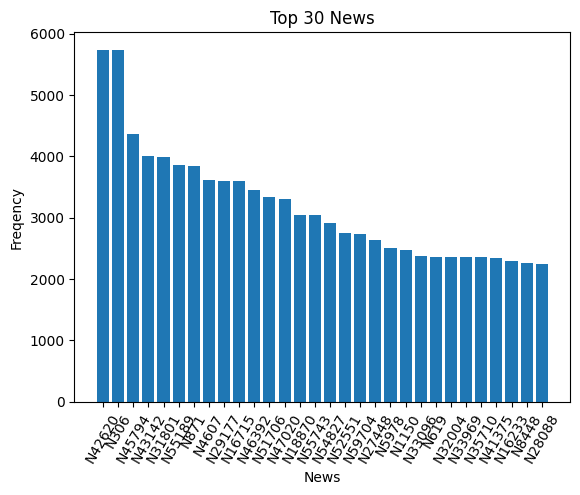

In [9]:
data = [item for sublist in history for item in sublist]

# 使用Counter计算元素的频率
element_counts = Counter(data)

# 选择前30个最常出现的元素
top_elements = 30
top_elements_data = element_counts.most_common(top_elements)

# 提取元素和频率
elements = [item[0] for item in top_elements_data]
frequencies = [item[1] for item in top_elements_data]

# 绘制频数直方图
plt.bar(elements, frequencies)
plt.xlabel('News')
plt.ylabel('Freqency')
plt.title('Top {} News'.format(top_elements))
plt.xticks(rotation=60)
plt.show()

对从用户新闻浏览模式的频繁项集中挖掘到的关联规则进行可视化的图网络展示

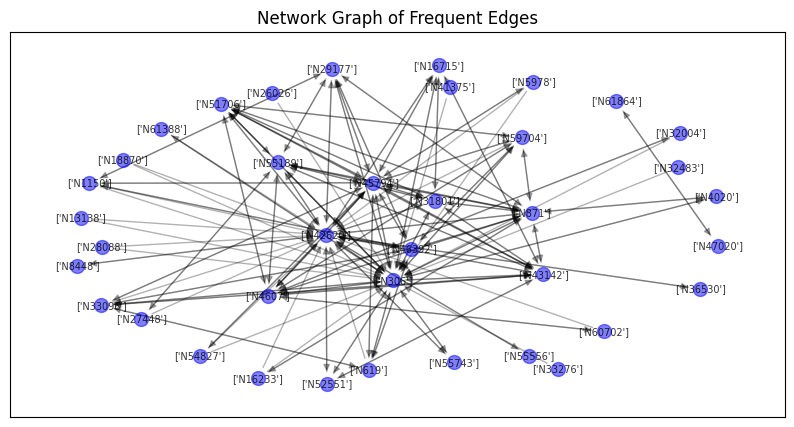

In [10]:
# 创建一个有向图
G = nx.DiGraph()

# 添加节点和边
for index, row in rule_1.iterrows():
    antecedents = list(row['antecedents'])
    consequents = list(row['consequents'])
    # 添加节点和边
    G.add_node(str(antecedents), label=str(antecedents))
    G.add_node(str(consequents), label=str(consequents))
    G.add_edge(str(antecedents), str(consequents))

# 绘制网络图
pos = nx.spring_layout(G,k=2)  # 使用Spring布局显示图
plt.figure(figsize=(10,5))
nx.draw_networkx_nodes(G, pos, node_size=100, node_color='blue', alpha=0.5)
nx.draw_networkx_edges(G, pos, alpha=0.3)
# 绘制节点标签
node_labels = nx.get_node_attributes(G, 'label',)
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=7, font_color='black',alpha=0.8)


plt.title('Network Graph of Frequent Edges')
plt.show()


## 二、高能物理论文引用模式挖掘
### 1、数据的获取和预处理
#### 1.1 数据的获取和介绍

Arxiv HEP-PH（高能物理现象学）引文数据集来自于arXiv，涵盖了34,546篇论文的所有引文，共有421,578条边。如果论文 i 引用了论文 j，则该图包含从 i 到 j 的有向边。如果一篇论文引用了数据集之外的论文，或者被数据集之外的论文引用，则图表不包含任何与此相关的信息。

数据涵盖1993年1月至2003年4月（124个月）期间的论文。它始于arXiv成立后的几个月内，因此基本上代表了其HEP-PH部分的完整历史。

对于引文的边数据，可以进行频繁模式挖掘以了解高能物理现象学领域论文的互相引用的模式。

In [11]:
def download_file(url, path):
    try:
        filename = os.path.basename(url)
        target = os.path.join(path, filename)
        if os.path.exists(target):
            print(f"{filename}文件已存在。")
            return
    
        response = requests.get(url,stream=True)

        if response.status_code == 200:
            
            os.makedirs(path, exist_ok=True)
            with open(target, "wb") as f:
                f.write(response.content)
            print(f"{filename}文件下载成功！")

            with gzip.open(target, 'rb') as gz:
                with open(os.path.join(path, filename[:-3]), 'wb') as f_out:
                    f_out.write(gz.read())
        else:
            print("文件下载失败：", response.status_code)
    except Exception as e:
        print("文件下载失败：", e)

url = "https://snap.stanford.edu/data/cit-HepPh.txt.gz"  
path = "./cit/" 
download_file(url, path)

cit-HepPh.txt.gz文件已存在。


#### 1.2 数据预处理

读取引文的边数据，数据中不存在Nan数据，数据完整性较高。

In [12]:
data = pd.read_csv(os.path.join(path,'cit-HepPh.txt'), delimiter='\t', header=None, skiprows=4, names=['FromNodeId', 'ToNodeId'])

data

,FromNodeId,ToNodeId
0,9907233,9301253
1,9907233,9504304
2,9907233,9505235
3,9907233,9506257
4,9907233,9606402
...,...,...
421573,9912461,9305269
421574,9912461,9609445
421575,9912461,9902379
421576,9912461,9902403


为了便于后续进行频繁模式挖掘，将同一论文的所有引文放在一个列表中

In [13]:
# 按照"FromNodeId"列进行分组，并将"ToNodeId"列转换为整数列表
grouped_data = data.groupby("FromNodeId")["ToNodeId"].apply(list)

# 将每个分组的"ToNodeId"列表拼接成所需的形式
formatted_data = [[] + value for key, value in grouped_data.items()]

### 2、 高能物理论文引用模式进行频繁模式挖掘
#### 2.1 频繁模式挖掘和分析

**模式命名**

对于从HepTh的引用数据中使用**FP-Growth算法**进行频繁模式挖掘获得的频繁项集中存在的模式，我们将其命名为**高能物理论文引用模式**。

通过论文引用模式，我们能更好的发现论文之间的关联关系，对在HepTh领域论文的阅读和引文的分类具有指导性作用

In [14]:
data = formatted_data
# 将数据格式转换为适合mxtend处理的格式
te = TransactionEncoder()
te_ary = te.fit(data).transform(data)
df = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = fpgrowth(df, min_support=0.01, use_colnames=True)

frequent_itemsets

,support,itemsets
0,0.026308,(9803315)
1,0.013962,(9905221)
2,0.012407,(9807216)
3,0.015642,(9807344)
4,0.012003,(9903282)
5,0.010666,(9209205)
6,0.010666,(9803445)
7,0.019155,(9804398)
8,0.016854,(9606399)
9,0.010573,(9209232)


以上是对HepTh引文进行的频繁模式挖掘，从挖掘结果可以看到，支持度大于等于1％的频繁项集大部分为1项集，少部分为2项集，可见论文引用模式中引文之间具有一定程度的关联性。

In [15]:
# 根据频繁项集生成关联规则
rule = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
rule.sort_values(by='leverage', ascending=False, inplace=True)  
rule

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
10,(9803315),(9804398),0.026308,0.019155,0.018036,0.685579,35.790350,0.017532,3.119528,0.998323
11,(9804398),(9803315),0.019155,0.026308,0.018036,0.941558,35.790350,0.017532,16.660959,0.991043
1,(9807344),(9803315),0.015642,0.026308,0.014149,0.904573,34.384450,0.013737,10.203485,0.986345
2,(9803315),(9807344),0.026308,0.015642,0.014149,0.537825,34.384450,0.013737,2.129840,0.997150
12,(9408384),(9507378),0.013807,0.013620,0.012190,0.882883,64.821342,0.012002,8.422166,0.998357
13,(9507378),(9408384),0.013620,0.013807,0.012190,0.894977,64.821342,0.012002,9.390274,0.998168
3,(9807344),(9804398),0.015642,0.019155,0.011506,0.735586,38.400958,0.011206,3.709510,0.989435
4,(9804398),(9807344),0.019155,0.015642,0.011506,0.600649,38.400958,0.011206,2.464898,0.992980
5,"(9807344, 9803315)",(9804398),0.014149,0.019155,0.011070,0.782418,40.845754,0.010799,4.507922,0.989518
9,(9804398),"(9807344, 9803315)",0.019155,0.014149,0.011070,0.577922,40.845754,0.010799,2.335709,0.994569



对于频繁项集，通过置信度（confidence）进行筛选，保留置信度大于等于50％的项集，再根据数据间的杠杆（leverage）对项集进行排序，以更好的发现关联规则中项集之间的相互关系。

对于表中的数据，我们可以知道，就论文引用关系而言，(9803315)→(9804398)的支持度有	0.018036，置信度有0.685579，且两者的杠杆leverage值也有0.017532,这说明9803315与9804398这两个论文关联程度较高，即引用过9803315的文章，有较高概率也会引用9804398；对于(9807344, 9803315)→(9804398)	，其支持度有0.011070，置信度有0.782418，且两者的杠杆leverage值也有0.010799,这说明同时引用了9807344, 9803315这两个引文的文章，有较高概率也会引用9804398，对于表中的其他引文也是如此。

#### 2.2 可视化分析

查看在引文中最常出现的前30个引文

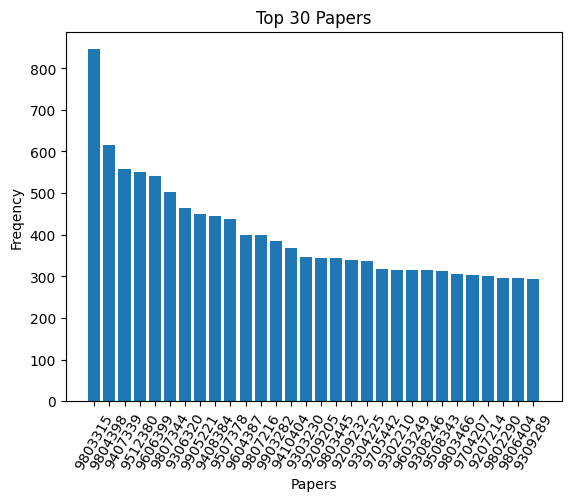

In [16]:
data = [item for sublist in formatted_data for item in sublist]

# 使用Counter计算元素的频率
element_counts = Counter(data)

# 选择前30个最常出现的元素
top_elements = 30
top_elements_data = element_counts.most_common(top_elements)

# 提取元素和频率
elements = [str(item[0]) for item in top_elements_data]
frequencies = [item[1] for item in top_elements_data]

# 绘制频数直方图
plt.bar(elements, frequencies)
plt.xlabel('Papers')
plt.ylabel('Freqency')
plt.title('Top {} Papers'.format(top_elements))
plt.xticks(rotation=60)
plt.show()

对从HepTh论文引用模式的频繁项集中挖掘到的关联规则进行可视化的图网络展示

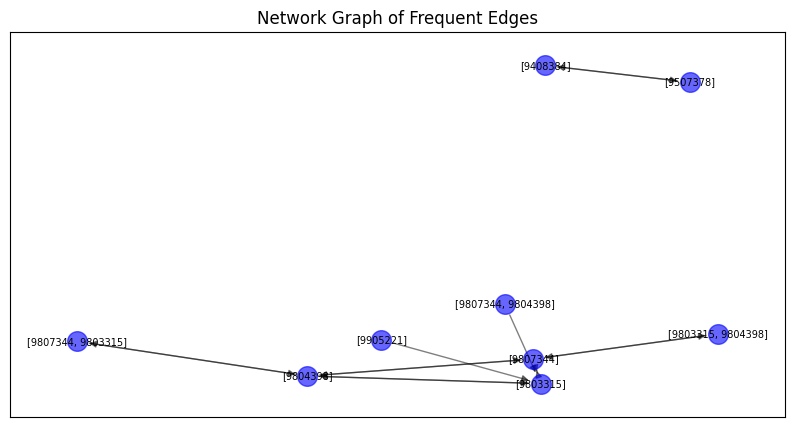

In [17]:

# 创建一个有向图
G = nx.DiGraph()

# 添加节点和边
for index, row in rule.iterrows():
    antecedents = list(row['antecedents'])
    consequents = list(row['consequents'])
    # 添加节点和边
    G.add_node(str(antecedents), label=str(antecedents))
    G.add_node(str(consequents), label=str(consequents))
    G.add_edge(str(antecedents), str(consequents))

# 绘制网络图
pos = nx.spring_layout(G)  # 使用Spring布局显示图
plt.figure(figsize=(10,5))
nx.draw_networkx_nodes(G, pos, node_size=200, node_color='blue', alpha=0.6)
nx.draw_networkx_edges(G, pos, alpha=0.5)
# 绘制节点标签
node_labels = nx.get_node_attributes(G, 'label',)
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=7, font_color='black')


plt.title('Network Graph of Frequent Edges')
plt.show()
